## Fitting to the pneumo data

Let's get the imports and data sorted first...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
import scipy.special as spec
from scipy.stats import norm, lognorm, expon, multinomial
import seaborn as sns
import pandas as pd
import corner
import scipy.optimize as sco
from getdist import plots, MCSamples
import time

In [2]:
pneumodata = pd.read_excel('/Users/Rob/Box/Pneumo_DATA/carriage_episodes_AL.xlsx')

In [3]:
pneumodata

,start_date,end_date,t_i,t_f,length_dates,bday,age_d,length,serotype,lanes
0,2004-11-18,2005-01-27,373,443.0,70.0,2003-11-20,364,95,19F,6680_7#22
1,2005-02-19,2005-02-19,466,466.0,0.0,2003-11-20,457,24,33B,6736_6#13
2,2005-01-09,2005-03-17,425,492.0,67.0,2003-11-20,416,79,6B,6736_6#13
3,2004-01-20,2004-01-20,70,70.0,0.0,2003-11-20,61,30,24F,6259_7#9
4,2004-03-24,2004-09-21,134,315.0,181.0,2003-11-20,125,213,NT,6664_1#5;6630_2#13;6630_4#13;6631_5#20;6730_1#...
...,...,...,...,...,...,...,...,...,...,...
4577,2006-03-02,2006-04-04,842,875.0,33.0,2004-04-03,698,46,34,6949_4#14;6972_3#11
4578,2005-08-31,2005-12-03,659,753.0,94.0,2004-04-03,515,124,19F,6823_2#10;6899_5#23;6899_7#15;6925_6#12
4579,2005-03-05,2005-05-04,480,540.0,60.0,2004-04-03,336,87,6A/C,6710_8#18
4580,2005-01-05,2005-01-05,421,421.0,0.0,2004-04-03,277,33,NT,NaN


In [4]:
pneumodata_removed_nonevents = pneumodata[pneumodata['length']>0.0]
serotype_labels = pneumodata_removed_nonevents['serotype'][pneumodata_removed_nonevents['serotype']!='NT'].unique()
bdays = pneumodata_removed_nonevents['bday'].unique()
print(serotype_labels)
print(str(len(serotype_labels)) + ' serotypes')
print(str(len(bdays)) + ' individuals')

['19F' '33B' '6B' '24F' 14 '10B' '33C' '10F' '6A/C' '23F' 34 '7F' '32A' 38
 '11A' '35C' '23A' 45 '15B/C' '15C' '18C' '19A' 8 '19B' '12F' '10A' '17F'
 '33D' 4 '15A' '9V' '28F' 13 31 '15B' '22F' '24A' 29 21 '23B' 5 '18F'
 '16F' '41F' 40 46 3 '35F' 20 1 '9A' '22A' '33F' 37 '7B' '9N' '25F' '32F'
 2 '9L' 36 '18A' '28A' 39 '18B' '12B' '35B' 48 42 '25A']
70 serotypes
294 individuals


In [5]:
state_labels = np.append('NT',serotype_labels)
number_codes = np.arange(0,len(serotype_labels)+1,1)
timescales_list = [np.asarray(pneumodata_removed_nonevents[pneumodata_removed_nonevents['bday']==b]['length']) \
                   for b in bdays]
state_list = [np.asarray([number_codes[(s==state_labels)][0] \
             for s in pneumodata_removed_nonevents[pneumodata_removed_nonevents['bday']==b]['serotype']]) \
             for b in bdays]

In [6]:
state_appearances = []
for nc in number_codes:
    count_total = 0
    for ind in state_list:
        count_total = count_total + np.count_nonzero(ind==nc)
    state_appearances.append(count_total)
state_appearances = np.asarray(state_appearances)
state_appearances

array([236, 405,  43, 320,  31, 259,  57,  28,  38, 332, 367, 153,  22,
         9,  59,  87, 136,  84,  14, 242,  38,  81, 146,  33,  47,  10,
        44,  33,  15,  56, 112,  64,  40,  96,  14,  56,  19,   2,  10,
        59,  53,  27,   4,  40,   3,  13,  23,  46,  42,  28,  18,   6,
        24,  19,   7,  21,  48,   2,   4,   1,  11,   1,  11,   3,   4,
         1,   1,   2,   5,   1,   2])

Rearrange according to state appearances...

In [7]:
number_codes[1:] = number_codes[1:][np.flip(np.argsort(state_appearances[1:]))]
state_appearances[1:] = state_appearances[1:][np.flip(np.argsort(state_appearances[1:]))]
print(number_codes,state_appearances)

[ 0  1 10  9  3  5 19 11 22 16 30 33 15 17 21 31 39 14  6 29 35 40 56 24
 47 26  2 48 43 32 20  8 23 27  4  7 49 41 52 46 12 55 36 53 50 28 18 34
 45 60 62 25 38 13 54 51 68 58 42 64 63 44 57 37 67 70 65 69 66 61 59] [236 405 367 332 320 259 242 153 146 136 112  96  87  84  81  64  59  59
  57  56  56  53  48  47  46  44  43  42  40  40  38  38  33  33  31  28
  28  27  24  23  22  21  19  19  18  15  14  14  13  11  11  10  10   9
   7   6   5   4   4   4   3   3   2   2   2   2   1   1   1   1   1]


### Use these to reduce data down to a meta-serotype...

In [8]:
reduce_by_number_of_serotypes = 28
number_codes = number_codes[:-(reduce_by_number_of_serotypes-1)]
summed_state_appearances = np.sum(state_appearances[-reduce_by_number_of_serotypes:])
state_appearances = state_appearances[:-(reduce_by_number_of_serotypes-1)]
state_appearances[-1] = summed_state_appearances

for personi in range(0,len(state_list)):
    for statei in range(0,len(state_list[personi])):
        if np.sum((state_list[personi][statei] == number_codes)) == 0:
            state_list[personi][statei] = number_codes[-1]
            
for personi in range(0,len(timescales_list)):
    unique, counts = np.unique(state_list[personi], return_counts=True)
    if np.any((unique == number_codes[-1])) == True:
        if counts[(unique == number_codes[-1])] > 1:
            new_state_seq = []
            new_timescales_seq = []
            for statei in range(0,len(timescales_list[personi])-1):
                if (state_list[personi][statei] == number_codes[-1]) and \
                   (state_list[personi][statei+1] == number_codes[-1]):
                    new_state_seq.append(state_list[personi][statei])
                    new_timescales_seq.append(timescales_list[personi][statei]+timescales_list[personi][statei+1])
                if (statei > 0) and (state_list[personi][statei] == number_codes[-1]) and \
                   (state_list[personi][statei-1] == number_codes[-1]):
                    do_nothing = 0
                if state_list[personi][statei] != number_codes[-1]:
                    new_state_seq.append(state_list[personi][statei])
                    new_timescales_seq.append(timescales_list[personi][statei])
            if (state_list[personi][len(state_list[personi])-1] != number_codes[-1]) or \
               (state_list[personi][len(state_list[personi])-2] != number_codes[-1]):
                new_state_seq.append(state_list[personi][len(state_list[personi])-1])
                new_timescales_seq.append(timescales_list[personi][len(state_list[personi])-1])
            state_list[personi] = np.asarray(new_state_seq)
            timescales_list[personi] = np.asarray(new_timescales_seq)
    
print(number_codes,state_appearances)

[ 0  1 10  9  3  5 19 11 22 16 30 33 15 17 21 31 39 14  6 29 35 40 56 24
 47 26  2 48 43 32 20  8 23 27  4  7 49 41 52 46 12 55 36 53] [236 405 367 332 320 259 242 153 146 136 112  96  87  84  81  64  59  59
  57  56  56  53  48  47  46  44  43  42  40  40  38  38  33  33  31  28
  28  27  24  23  22  21  19 193]


Look at empirical rate distribution shapes...

log-meanrectime: -5.405791032545559
log-meancoltime: -4.390643250934761
log-meancolcoltime: -5.105391559558501


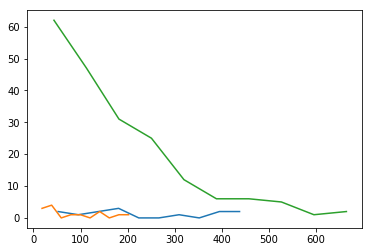

In [36]:
serotype_number_to_plot = 1
n_past_exposures = 0
rec_dat = []
col_dat = []
col_col_dat = []
for tl,sl in zip(timescales_list,state_list):
    past_exposures = 0
    for i in range(0,len(sl)-1):
        if (sl[i] == 0) and (sl[i+1] == serotype_number_to_plot) and \
           (past_exposures==n_past_exposures): 
            col_dat.append(tl[i])
        if (sl[i] == serotype_number_to_plot) and (sl[i+1] != 0) and \
           (past_exposures==n_past_exposures): 
            col_col_dat.append(tl[i])
        if (sl[i] == serotype_number_to_plot) and (sl[i+1] == 0) and \
           (past_exposures==n_past_exposures): 
            rec_dat.append(tl[i])
        if (sl[i] == serotype_number_to_plot):
            past_exposures += 1
            
v,b = np.histogram(rec_dat)
v1,b1 = np.histogram(col_dat)
v2,b2 = np.histogram(col_col_dat)
plt.plot(0.5*(b[1:]+b[:-1]),v)
plt.plot(0.5*(b1[1:]+b1[:-1]),v1)
plt.plot(0.5*(b2[1:]+b2[:-1]),v2)
meanrectime = float(len(rec_dat))/np.sum(np.asarray(rec_dat))
meancoltime = float(len(col_dat))/np.sum(np.asarray(col_dat))
meancolcoltime = float(len(col_col_dat))/np.sum(np.asarray(col_col_dat))
print('log-meanrectime: ' + str(np.log(meanrectime)))
print('log-meancoltime: ' + str(np.log(meancoltime)))
print('log-meancolcoltime: ' + str(np.log(meancolcoltime)))
plt.show()

Have a look at the trends in the estimated rates as a function of the number of past exposures...

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


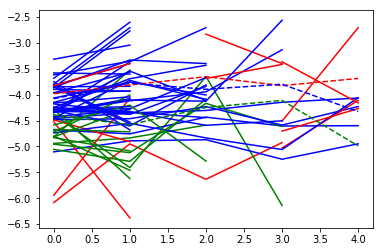

In [10]:
numexp = [0,1,2,3,4]

serotype_recmean = [[] for v in numexp]
serotype_colmean = [[] for v in numexp]
serotype_colcolmean = [[] for v in numexp]
for sn in number_codes[1:]:
    rec_numexp = []
    col_numexp = []
    col_col_numexp = []
    for ne in numexp:
        serotype_number = sn
        n_past_exposures = ne
        rec_dat = []
        col_dat = []
        col_col_dat = []
        for tl,sl in zip(timescales_list,state_list):
            past_exposures = 0
            past_specific_exposures = 0
            for i in range(0,len(sl)-1):
                if (sl[i] == 0) and (sl[i+1] == serotype_number) and \
                   (past_specific_exposures==n_past_exposures): 
                    col_dat.append(tl[i])
                if (sl[i] == serotype_number) and (sl[i+1] != 0) and \
                   (past_specific_exposures==n_past_exposures): 
                    col_col_dat.append(tl[i])
                if (sl[i] == serotype_number) and (sl[i+1] == 0) and \
                   (past_exposures==n_past_exposures): 
                    rec_dat.append(tl[i])
                if (sl[i] == serotype_number):
                    past_specific_exposures += 1
                if (sl[i] != 0):
                    past_exposures += 1
            
        meanrectime = float(len(rec_dat))/np.sum(np.asarray(rec_dat))
        meancoltime = float(len(col_dat))/np.sum(np.asarray(col_dat))
        meancolcoltime = float(len(col_col_dat))/np.sum(np.asarray(col_col_dat))
        
        rec_numexp.append(meanrectime)
        col_numexp.append(meancoltime)
        col_col_numexp.append(meancolcoltime)
        
        if np.isnan(meanrectime) == False: serotype_recmean[ne].append(meanrectime)
        if np.isnan(meancoltime) == False: serotype_colmean[ne].append(meancoltime)
        if np.isnan(meancolcoltime) == False: serotype_colcolmean[ne].append(meancolcoltime)

    plt.plot(numexp,np.log(np.asarray(rec_numexp)),color='r')
    plt.plot(numexp,np.log(np.asarray(col_numexp)),color='g')
    plt.plot(numexp,np.log(np.asarray(col_col_numexp)),color='b') 
    
serotype_averaged_recmean = [np.log(sum(serotype_recmean[ne])/len(serotype_recmean[ne])) for ne in numexp]
serotype_averaged_colmean = [np.log(sum(serotype_colmean[ne])/len(serotype_colmean[ne])) for ne in numexp]
serotype_averaged_colcolmean = [np.log(sum(serotype_colcolmean[ne])/len(serotype_colcolmean[ne])) for ne in numexp]
    
plt.plot(numexp,serotype_averaged_recmean ,'--',color='r')
plt.plot(numexp,serotype_averaged_colmean ,'--',color='g')
plt.plot(numexp,serotype_averaged_colcolmean ,'--',color='b')

plt.show()

In [11]:
n_past_exposures = 0
logmeanrectime_list = []
logmeancoltime_list = []
logmeancolcoltime_list = []

for serotype_number in number_codes[1:]:
    rec_dat = []
    col_dat = []
    col_col_dat = []
    for tl,sl in zip(timescales_list,state_list):
        past_exposures = 0
        for i in range(0,len(sl)-1):
            if (sl[i] == 0) and (sl[i+1] == serotype_number) and \
               (past_exposures==n_past_exposures): 
                col_dat.append(tl[i])
            if (sl[i] == serotype_number) and (sl[i+1] != 0) and \
               (past_exposures==n_past_exposures): 
                col_col_dat.append(tl[i])
            if (sl[i] == serotype_number) and (sl[i+1] == 0) and \
               (past_exposures==n_past_exposures): 
                rec_dat.append(tl[i])
            if (sl[i] == serotype_number):
                past_exposures += 1
            
    meanrectime = float(len(rec_dat))/np.sum(np.asarray(rec_dat))
    meancoltime = float(len(col_dat))/np.sum(np.asarray(col_dat))
    meancolcoltime = float(len(col_col_dat))/np.sum(np.asarray(col_col_dat))

    logmeanrectime_list.append(np.log(meanrectime))
    logmeancoltime_list.append(np.log(meancoltime))
    logmeancolcoltime_list.append(np.log(meancolcoltime))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
logmeanrectime_list = np.asarray(logmeanrectime_list)
logmeancoltime_list = np.asarray(logmeancoltime_list)
logmeancolcoltime_list = np.asarray(logmeancolcoltime_list)

In [13]:
logmeanrectime_list

array([-5.40579103, -5.55185155, -4.4765248 , -4.83230576, -4.87900685,
       -4.11496385, -3.8329798 , -4.56954301, -3.87120101, -3.76378076,
       -4.09988474, -3.79548919, -3.13549422, -3.77658503, -3.4339872 ,
       -4.20965541, -3.98898405,         nan, -3.09104245, -4.52178858,
       -3.40119738, -3.36729583, -4.18205014, -3.24519313, -3.4339872 ,
       -4.18205014, -3.35573501, -3.40119738, -4.51633897, -3.15700042,
       -3.40119738, -3.25809654, -4.09434456, -3.41224722, -3.65065824,
       -4.99043259, -2.7080502 , -3.8286414 , -4.65396035,         nan,
               nan, -3.8501476 , -3.59273559])

In [14]:
logmeancoltime_list

array([-4.39064325, -4.94259435, -4.95739078, -5.05730681, -4.83150863,
       -4.80128506, -4.81758977, -4.81624116, -4.90527478, -4.28358656,
       -4.58496748, -5.27556038, -4.32413266, -4.93447393, -4.3208159 ,
       -4.21582446, -3.9749978 , -5.0401941 , -5.22035583, -4.55987391,
       -5.79453684, -3.33220451, -4.75359019, -5.57215403, -4.72295322,
       -6.22059017, -3.21887582, -4.1640779 , -3.9982007 , -4.9698133 ,
       -4.36309862, -3.4339872 ,         nan,         nan, -4.24372196,
       -4.67282883, -4.34380542, -3.8140426 , -5.03043792,         nan,
               nan, -3.4339872 , -5.09497644])

In [15]:
logmeancolcoltime_list

array([-5.10539156, -4.68240352, -4.48638665, -4.73991959, -4.46121733,
       -4.3124649 , -4.31079913, -4.30620356, -4.34173088, -4.28528686,
       -4.15009458, -3.85045151, -4.24012699, -3.85908362, -4.27746708,
       -4.29135243, -3.58240721, -4.34711037, -3.84968496, -4.2501173 ,
       -4.45085283, -3.96252111, -3.9638019 , -3.68540119, -4.32450051,
       -4.42684065, -4.34715131, -4.32302829, -4.06637071, -3.86615959,
       -4.32908725, -3.79593853, -4.17986674, -3.81954215, -4.32238837,
       -3.82515707, -3.31781577, -3.89780476, -3.61800511, -3.75012308,
       -4.16298649, -3.75990729, -4.01271329])

In [16]:
#logmeanrectime_list[np.isnan(logmeanrectime_list)] = -4.0
#logmeancoltime_list[np.isnan(logmeancoltime_list)] = -4.0
#logmeancolcoltime_list = np.nan_to_num(logmeancolcoltime_list)

Map some new number codes to the state list...

In [17]:
new_number_codes = np.arange(0,len(number_codes),1)
new_state_list = [np.asarray([new_number_codes[(number_codes==state_list[personi][statei])][0] \
                               for statei in range(0,len(state_list[personi]))]) \
                               for personi in range(0,len(state_list))]

In [18]:
print(state_list)

[array([1, 2, 3, 4, 0]), array([5, 6]), array([5, 1, 7, 0]), array([ 1,  8,  5,  3,  9,  0, 10, 11, 32, 46,  9, 15, 16, 46, 16, 47, 19,
       21,  7]), array([ 1, 12, 11,  1,  0,  9,  6, 14,  0, 22, 10,  0, 26,  3,  5,  5,  9]), array([15, 16,  1,  5, 10, 16, 17, 12, 29]), array([53,  9, 19, 20,  1, 33, 35,  1, 19]), array([16, 21, 10, 22,  0, 15, 53,  9, 19, 11, 10, 10,  6, 30,  5, 31,  1,
        2,  3, 32,  9,  1,  1, 10]), array([ 0, 23, 24]), array([53, 26, 27, 15,  9,  1, 16,  0, 10]), array([12, 19,  1,  0]), array([22, 22,  3, 19, 16, 26, 10,  5,  1, 35, 19, 16, 12]), array([32,  3, 33, 53, 17,  3,  1, 10, 10]), array([36, 26,  3,  1, 10,  2,  3, 10,  1, 33, 30,  4,  5, 30, 14, 10, 41]), array([21, 35, 19, 17,  3, 11,  2,  9,  0,  6,  9,  3, 30,  1,  9,  1,  0,
       22,  3, 26,  1, 10]), array([30, 10,  3,  1,  0, 35,  3, 16, 29, 36,  1, 46, 20, 17, 15, 33, 23,
       27,  3, 19]), array([24, 23, 17,  3,  3,  9,  0,  5]), array([10, 39, 40, 30,  0, 31, 27, 22]), array([17, 5

In [19]:
print(new_state_list)

[array([ 1, 26,  4, 34,  0]), array([ 5, 18]), array([ 5,  1, 35,  0]), array([ 1, 31,  5,  4,  3,  0,  2,  7, 29, 39,  3, 12,  9, 39,  9, 24,  6,
       14, 35]), array([ 1, 40,  7,  1,  0,  3, 18, 17,  0,  8,  2,  0, 25,  4,  5,  5,  3]), array([12,  9,  1,  5,  2,  9, 13, 40, 19]), array([43,  3,  6, 30,  1, 11, 20,  1,  6]), array([ 9, 14,  2,  8,  0, 12, 43,  3,  6,  7,  2,  2, 18, 10,  5, 15,  1,
       26,  4, 29,  3,  1,  1,  2]), array([ 0, 32, 23]), array([43, 25, 33, 12,  3,  1,  9,  0,  2]), array([40,  6,  1,  0]), array([ 8,  8,  4,  6,  9, 25,  2,  5,  1, 20,  6,  9, 40]), array([29,  4, 11, 43, 13,  4,  1,  2,  2]), array([42, 25,  4,  1,  2, 26,  4,  2,  1, 11, 10, 34,  5, 10, 17,  2, 37]), array([14, 20,  6, 13,  4,  7, 26,  3,  0, 18,  3,  4, 10,  1,  3,  1,  0,
        8,  4, 25,  1,  2]), array([10,  2,  4,  1,  0, 20,  4,  9, 19, 42,  1, 39, 30, 13, 12, 11, 32,
       33,  4,  6]), array([23, 32, 13,  4,  4,  3,  0,  5]), array([ 2, 16, 21, 10,  0, 15, 33,  8]), a

### Model using times with immunity

Note here that the competition matrix is assumed to be $f_{ii'}=f_i\mathbb{1}_{i'}$.

Parameters include...

$$\tilde{\mu}_i = \tilde{\mu}_i\bigg( \sum_{\forall i}n_i \bigg) = \mu_i\exp \bigg( \sigma \sum_{\forall i}n_i \bigg)$$

$$\tilde{\Lambda}_i = \tilde{\Lambda}_i(n_i) = \Lambda_{i}\exp \bigg( -\epsilon n_i \bigg)$$

In [20]:
def mut_f(ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    mus = np.exp(lnmus)
    return np.tensordot(mus,np.ones_like(ns[0]),axes=0)*\
           np.exp(sigma*np.tensordot(np.ones_like(mus),np.sum(ns,axis=0),axes=0))

def Lamt_f(ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    return np.tensordot(Lams,np.ones_like(ns[0]),axes=0)*np.exp(-eps*ns) 

Log-likelihoods are...

$$\ln {\cal L}_{x_i\rightarrow y}(\delta t) = \ln  \tilde{\mu}_{i} - \left(  \tilde{\mu}_{i}  + \sum_{\forall i' \neq i}f_{i}\tilde{\Lambda}_{i'}\right) \delta t $$

$$\ln {\cal L}_{y\rightarrow x_i}(\delta t) = \ln  \tilde{\Lambda}_{i} - \left(  \tilde{\Lambda}_{i} + \sum_{\forall i' \neq i}\tilde{\Lambda}_{i'}\right) \delta t $$

$$\ln {\cal L}_{x_i\rightarrow x_{i'}}(\delta t) = \ln  f_{i}\tilde{\Lambda}_{i'} - \left( f_{i}\tilde{\Lambda}_{i'} + \tilde{\mu}_{i} + \sum_{\forall i'' \neq i,i'}f_{i}\tilde{\Lambda}_{i''}\right) \delta t $$

In [21]:
def lnLikexy_f(deltat,i,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    fs = np.exp(lnfs)
    muts = mut_f(ns,params=params)
    Lamts = Lamt_f(ns,params=params)
    Lams_for_sum = np.tensordot(Lams,np.ones_like(ns[0]),axes=0)
    Lamtsums = np.sum(Lams_for_sum,axis=0) - Lamts[i]
    return np.log(muts[i]) - ((muts[i]+(fs[i]*Lamtsums))*deltat)

def lnLikeyx_f(deltat,i,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    Lamts = Lamt_f(ns,params=params)
    Lams_for_sum = np.tensordot(Lams,np.ones_like(ns[0]),axes=0)
    Lamtsums = np.sum(Lams_for_sum,axis=0)
    return np.log(Lamts[i]) - (Lamtsums*deltat)

def lnLikexx_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    fs = np.exp(lnfs)
    Lamts = Lamt_f(ns,params=params)
    muts = mut_f(ns,params=params)
    Lams_for_sum = np.tensordot(Lams,np.ones_like(ns[0]),axes=0)
    Lamtsum = np.sum(Lams_for_sum,axis=0) - Lamts[i]
    return np.log(fs[i]*Lamts[ip]) - ((muts[i]+(fs[i]*Lamtsum))*deltat)

Derivatives of these are, for $\mu_i$...

$$\frac{\partial \tilde{\mu}_i}{\partial \ln\mu_{i'}} = \mu_{i'}\frac{\partial \tilde{\mu}_i}{\partial \mu_{i'}} = \delta_{ii'}\mu_{i'}\exp \bigg( \sigma \sum_{\forall i}n_i \bigg)$$

$$\frac{\partial}{\partial \ln \mu_{i'}}\ln {\cal L}_{x_i\rightarrow y}(\delta t) = \frac{1}{\tilde{\mu}_{i}}\frac{\partial \tilde{\mu}_{i}}{\partial \ln\mu_{i'}} -   \frac{\partial \tilde{\mu}_{i}}{\partial \ln\mu_{i'}} \delta t$$

$$\frac{\partial}{\partial \ln \mu_{i'}}\ln {\cal L}_{y\rightarrow x_i}(\delta t) = 0$$

$$\frac{\partial}{\partial \ln \mu_{i''}}\ln {\cal L}_{x_i\rightarrow x_{i'}}(\delta t) = - \frac{\partial \tilde{\mu}_{i}}{\partial \ln\mu_{i''}} \delta t$$

In [22]:
def dlnLikexydlnmu_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    mus = np.exp(lnmus)
    dmutidlnmuip = np.zeros((len(lnmus),len(ns[0])))
    dmutidlnmuip[i,:] = (i==ip)*mus[ip]*np.exp(sigma*np.sum(ns,axis=0))
    muts = mut_f(ns,params=params)
    return (dmutidlnmuip/muts)-(dmutidlnmuip*deltat)

def dlnLikeyxdlnmu_f(deltat,i,ip,ns,params=None):
    return 0.0

def dlnLikexxdlnmu_f(deltat,i,ip,ipp,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    mus = np.exp(lnmus)
    dmutidlnmuipp = np.zeros((len(lnmus),len(ns[0])))
    dmutidlnmuipp[i,:] = (i==ipp)*mus[i]*np.exp(sigma*np.sum(ns,axis=0))
    return -dmutidlnmuipp*deltat

for $\Lambda_i$...

$$\frac{\partial \tilde{\Lambda}_i}{\partial \ln \Lambda_{i'}} = \Lambda_{i'}\frac{\partial \tilde{\Lambda}_i}{\partial \Lambda_{i'}} =  \Lambda_{i'}\delta_{ii'}\exp \bigg( -\epsilon n_i \bigg)$$

$$\frac{\partial}{\partial \ln \Lambda_{i'}}\ln {\cal L}_{x_i\rightarrow y}(\delta t) =  -\sum_{\forall i'' \neq i}f_{i}\frac{\partial \tilde{\Lambda}_{i''}}{\partial \ln \Lambda_{i'}}\delta t $$

$$\frac{\partial}{\partial \ln \Lambda_{i'}}\ln {\cal L}_{y\rightarrow x_i}(\delta t) = \frac{1}{\tilde{\Lambda}_{i}}\frac{\partial \tilde{\Lambda}_{i}}{\partial \ln \Lambda_{i'}} - \left(  \frac{\partial \tilde{\Lambda}_{i}}{\partial \ln \Lambda_{i'}} + \sum_{\forall i'' \neq i}\frac{\partial \tilde{\Lambda}_{i''}}{\partial \ln \Lambda_{i'}}\right) \delta t $$

$$\frac{\partial}{\partial \ln \Lambda_{i''}}\ln {\cal L}_{x_i\rightarrow x_{i'}}(\delta t) = \frac{1}{\tilde{\Lambda}_{i'}}\frac{\partial \tilde{\Lambda}_{i'}}{\partial \ln \Lambda_{i''}} - \left( f_{i}\frac{\partial \tilde{\Lambda}_{i'}}{\partial \ln \Lambda_{i''}} + \sum_{\forall i''' \neq i,i'}f_{i}\frac{\partial \tilde{\Lambda}_{i'''}}{\partial \ln \Lambda_{i''}}\right) \delta t $$

In [23]:
def dlnLikexydlnLam_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    fs = np.exp(lnfs)
    fidLamtdlnLamsum = np.zeros((len(lnLams),len(ns[0])))
    fidLamtdlnLamsum[ip,:] = (i!=ip)*fs[i]*Lams[ip]*np.exp(-eps*ns[ip])
    return -fidLamtdlnLamsum*deltat

def dlnLikeyxdlnLam_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    Lamts = Lamt_f(ns,params=params)
    dLamtidlnLamip = np.zeros((len(lnLams),len(ns[0])))
    dLamtdlnLamsum = np.zeros((len(lnLams),len(ns[0])))
    dLamtidlnLamip[ip,:] = (i==ip)*Lams[i]*np.exp(-eps*ns[i])
    dLamtdlnLamsum[ip,:] = Lams[ip]*np.exp(-eps*ns[ip])
    return (dLamtidlnLamip/Lamts) - (dLamtdlnLamsum*deltat)

def dlnLikexxdlnLam_f(deltat,i,ip,ipp,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lams = np.exp(lnLams)
    fs = np.exp(lnfs)
    Lamts = Lamt_f(ns,params=params)
    dLamtipdlnLamipp = np.zeros((len(lnLams),len(ns[0])))
    fidLamtdlnLamsum = np.zeros((len(lnLams),len(ns[0]))) 
    dLamtipdlnLamipp[ipp,:] = (ip==ipp)*Lams[ip]*np.exp(-eps*ns[ip])
    fidLamtdlnLamsum[ipp,:] = (ipp!=i)*fs[i]*Lams[ipp]*np.exp(-eps*ns[ipp])
    return (dLamtipdlnLamipp/Lamts)-(fidLamtdlnLamsum*deltat)

for $f_i$...

$$\frac{\partial}{\partial \ln f_{i'}}\ln {\cal L}_{x_i\rightarrow y}(\delta t) = - \sum_{\forall i'' \neq i}f_{i'}\delta_{ii'}\tilde{\Lambda}_{i''} \delta t $$

$$\frac{\partial}{\partial \ln f_{i'}}\ln {\cal L}_{y\rightarrow x_i}(\delta t) = 0$$

$$\frac{\partial}{\partial \ln f_{i''}}\ln {\cal L}_{x_i\rightarrow x_{i'}}(\delta t) = \delta_{ii''} - \left( f_{i''}\delta_{ii''}\tilde{\Lambda}_{i'} + \sum_{\forall i''' \neq i,i'}f_{i''}\delta_{ii''}\tilde{\Lambda}_{i'''}\right) \delta t $$

In [24]:
def dlnLikexydlnf_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    fs = np.exp(lnfs)
    Lamts = Lamt_f(ns,params=params)
    fipLamtsum = np.zeros((len(lnfs),len(ns[0])))
    fipLamtsum[ip,:] = (ip==i)*fs[ip]*(np.sum(Lamts,axis=0)-Lamts[i])
    return -fipLamtsum*deltat

def dlnLikeyxdlnf_f(deltat,i,ip,ns,params=None):
    return 0.0

def dlnLikexxdlnf_f(deltat,i,ip,ipp,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    fs = np.exp(lnfs)
    Lamts = Lamt_f(ns,params=params)
    kron = np.zeros((len(lnfs),len(ns[0])))
    fippLamtsum = np.zeros((len(lnfs),len(ns[0])))
    kron[ipp,:] = (i==ipp)*1.0
    fippLamtsum[ipp,:] =  fs[ipp]*(np.sum(Lamts,axis=0) - Lamts[i])
    return kron*(1.0 - (fippLamtsum*deltat))

for $\epsilon$...

$$\frac{\partial \tilde{\Lambda}_i}{\partial \epsilon} = -n_i \Lambda_{i}\exp \bigg( -\epsilon n_i \bigg)$$

$$\frac{\partial}{\partial \epsilon}\ln {\cal L}_{x_i\rightarrow y}(\delta t) = - \sum_{\forall i' \neq i}f_{i}\frac{\partial \tilde{\Lambda}_{i'}}{\partial \epsilon}\delta t $$

$$\frac{\partial}{\partial \epsilon}\ln {\cal L}_{y\rightarrow x_i}(\delta t) = \frac{1}{\tilde{\Lambda}_{i}} \frac{\partial \tilde{\Lambda}_{i}}{\partial \epsilon} - \left(  \frac{\partial \tilde{\Lambda}_{i}}{\partial  \epsilon}  + \sum_{\forall i' \neq i}\frac{\partial \tilde{\Lambda}_{i'}}{\partial \epsilon}\right) \delta t $$

$$\frac{\partial}{\partial \epsilon}\ln {\cal L}_{x_i\rightarrow x_{i'}}(\delta t) = \frac{1}{\tilde{\Lambda}_{i'}}\frac{\partial \tilde{\Lambda}_{i'}}{\partial \epsilon} - \left( f_{i}\frac{\partial \tilde{\Lambda}_{i'}}{\partial \epsilon} + \sum_{\forall i'' \neq i,i'}f_{i}\frac{\partial \tilde{\Lambda}_{i''}}{\partial \epsilon}\right) \delta t $$

In [25]:
def dlnLikexydeps_f(deltat,i,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    fs = np.exp(lnfs)
    Lams = np.exp(lnLams)
    Lams_for_sum = np.tensordot(Lams,np.ones_like(ns[0]),axes=0)
    dLamtdepssum = np.sum(-ns*Lams_for_sum*np.exp(-eps*ns),axis=0) + \
                   ns[i]*Lams[i]*np.exp(-eps*ns[i])
    return -fs[i]*dLamtdepssum*deltat

def dlnLikeyxdeps_f(deltat,i,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lamts = Lamt_f(ns,params=params)
    Lams = np.exp(lnLams)
    dLamtideps = -ns[i]*Lams[i]*np.exp(-eps*ns[i])
    Lams_for_sum = np.tensordot(Lams,np.ones_like(ns[0]),axes=0)
    dLamtdepssum = np.sum(-ns*Lams_for_sum*np.exp(-eps*ns),axis=0)
    return (dLamtideps/Lamts[i]) - (dLamtdepssum*deltat)

def dlnLikexxdeps_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    Lamts = Lamt_f(ns,params=params)
    fs = np.exp(lnfs)
    Lams = np.exp(lnLams)
    dLamtipdeps = -ns[ip]*Lams[ip]*np.exp(-eps*ns[ip])
    Lams_for_sum = np.tensordot(Lams,np.ones_like(ns[0]),axes=0)
    dLamtdepssum = np.sum(-ns*Lams_for_sum*np.exp(-eps*ns),axis=0) + \
                   ns[i]*Lams[i]*np.exp(-eps*ns[i])
    return (dLamtipdeps/Lamts[ip]) - (fs[i]*dLamtdepssum*deltat)

for $\sigma$...

$$\frac{\partial \tilde{\mu}_i}{\partial \sigma} = \mu_i \exp \bigg( \sigma \sum_{\forall i}n_i \bigg)\sum_{\forall i}n_i $$

$$\frac{\partial}{\partial \sigma}\ln {\cal L}_{x_i\rightarrow y}(\delta t) = \frac{1}{\tilde{\mu}_{i}}\frac{\partial \tilde{\mu}_{i}}{\partial \sigma} - \frac{\partial \tilde{\mu}_{i}}{\partial \sigma} \delta t $$

$$\frac{\partial}{\partial \sigma}\ln {\cal L}_{y\rightarrow x_i}(\delta t) = 0$$

$$\frac{\partial}{\partial \sigma}\ln {\cal L}_{x_i\rightarrow x_{i'}}(\delta t) = - \frac{\partial \tilde{\mu}_{i}}{\partial \sigma}\delta t \,.$$

In [26]:
def dlnLikexydsigma_f(deltat,i,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    mus = np.exp(lnmus)
    muts = mut_f(ns,params=params)
    dmutidsigma = np.sum(ns,axis=0)*mus[i]*np.exp(sigma*np.sum(ns,axis=0))
    return (dmutidsigma/muts[i]) - (dmutidsigma*deltat)

def dlnLikeyxdsigma_f(deltat,i,ns,params=None):
    return 0.0

def dlnLikexxdsigma_f(deltat,i,ip,ns,params=None):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    mus = np.exp(lnmus)
    dmutidsigma = np.sum(ns,axis=0)*mus[i]*np.exp(sigma*np.sum(ns,axis=0))
    return -dmutidsigma*deltat

Now to compute the maximum likelihood using the first derivatives...

In [28]:
dim = len(number_codes[1:])

def lnlikelihood_first_deriv(params,data_labels=new_number_codes,data=[new_state_list,timescales_list]):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    [state_list,timescales_list] = data
    state_labels = data_labels
    
    # Set likelihood derivative contributions for the specific parameters
    def lnLikexy(deltat,i,ns): return lnLikexy_f(deltat,i,ns,params=params)
    def lnLikeyx(deltat,i,ns): return lnLikeyx_f(deltat,i,ns,params=params)
    def lnLikexx(deltat,i,ip,ns): return lnLikexx_f(deltat,i,ip,ns,params=params)
    def dlnLikexydlnmu(deltat,i,ip,ns): return dlnLikexydlnmu_f(deltat,i,ip,ns,params=params)
    def dlnLikeyxdlnmu(deltat,i,ip,ns): return dlnLikeyxdlnmu_f(deltat,i,ip,ns,params=params)
    def dlnLikexxdlnmu(deltat,i,ip,ipp,ns): return dlnLikexxdlnmu_f(deltat,i,ip,ipp,ns,params=params)
    def dlnLikexydlnLam(deltat,i,ip,ns): return dlnLikexydlnLam_f(deltat,i,ip,ns,params=params)
    def dlnLikeyxdlnLam(deltat,i,ip,ns): return dlnLikeyxdlnLam_f(deltat,i,ip,ns,params=params)
    def dlnLikexxdlnLam(deltat,i,ip,ipp,ns): return dlnLikexxdlnLam_f(deltat,i,ip,ipp,ns,params=params)
    def dlnLikexydlnf(deltat,i,ip,ns): return dlnLikexydlnf_f(deltat,i,ip,ns,params=params)
    def dlnLikeyxdlnf(deltat,i,ip,ns): return dlnLikeyxdlnf_f(deltat,i,ip,ns,params=params)
    def dlnLikexxdlnf(deltat,i,ip,ipp,ns): return dlnLikexxdlnf_f(deltat,i,ip,ipp,ns,params=params)
    def dlnLikexydeps(deltat,i,ns): return dlnLikexydeps_f(deltat,i,ns,params=params)
    def dlnLikeyxdeps(deltat,i,ns): return dlnLikeyxdeps_f(deltat,i,ns,params=params)
    def dlnLikexxdeps(deltat,i,ip,ns): return dlnLikexxdeps_f(deltat,i,ip,ns,params=params)
    def dlnLikexydsigma(deltat,i,ns): return dlnLikexydsigma_f(deltat,i,ns,params=params)
    def dlnLikeyxdsigma(deltat,i,ns): return dlnLikeyxdsigma_f(deltat,i,ns,params=params)
    def dlnLikexxdsigma(deltat,i,ip,ns): return dlnLikexxdsigma_f(deltat,i,ip,ns,params=params)
    
    # Construct derivatives storage
    lfds = np.append(np.zeros_like(sigma),np.zeros_like(eps))
    lfds = np.append(lfds,np.zeros_like(lnmus))
    lfds = np.append(lfds,np.zeros_like(lnLams))
    lfds = np.append(lfds,np.zeros_like(lnfs))
    
    # Construct log-likelihood storage
    llike = 0.0
    
    # Loop over individuals
    for (ind,dt) in zip(state_list,timescales_list):
        
        # Change to array format for faster computation
        ind = np.asarray(ind)
        dt = np.asarray(dt)
        
        # Create cumulative colonisations numbers for this individual
        ind_matrix = np.tensordot(np.ones_like(data_labels[1:]),np.append(0,ind[:-1]),axes=0)
        data_labels_matrix = np.tensordot(data_labels[1:],np.ones_like(ind),axes=0)
        ns_time = (ind_matrix==data_labels_matrix)
        
        # Encode 0 for x->y; 1 for y->x; and 2 for x->x
        transitions = np.zeros(len(ind)-1)
        transitions[(ind[:-1]==0) & (ind[1:]!=0)] = 1
        transitions[(ind[:-1]!=0) & (ind[1:]!=0) & (ind[:-1]!=ind[1:])] = 2
        
        # Generate matrices for faster computation
        cumul_ns_time_matrix = np.cumsum(ns_time,axis=1)
        transitions_matrix = np.tensordot(np.ones_like(data_labels[1:]),transitions,axes=0)
        
        # Evaluate the log-likelihood itself...
        llike = llike + np.sum((transitions==0)*lnLikexy(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                        np.sum((transitions==1)*lnLikeyx(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                        np.sum((transitions==2)*lnLikexx(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1]))
        
        # Contributions to sigma derivative
        lfds[0] = lfds[0]+np.sum((transitions==0)*dlnLikexydsigma(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                          np.sum((transitions==1)*dlnLikeyxdsigma(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                    np.sum((transitions==2)*dlnLikexxdsigma(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1]))
        
        # Contributions to eps derivative
        lfds[1] = lfds[1] + np.sum((transitions==0)*dlnLikexydeps(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                            np.sum((transitions==1)*dlnLikeyxdeps(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                    np.sum((transitions==2)*dlnLikexxdeps(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1])) 
        
        # Contributions to lnmu derivatives
        lfds[2:len(lnmus)+2] = lfds[2:len(lnmus)+2] +\
                               np.sum((transitions_matrix==0)*dlnLikexydlnmu(dt[:-1],ind[:-1]-1,\
                                                            ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1)+\
                               np.sum((transitions_matrix==1)*dlnLikeyxdlnmu(dt[:-1],ind[1:]-1,\
                                                            ind[1:]-1,cumul_ns_time_matrix[:,:-1]),axis=1)+\
                               np.sum((transitions_matrix==2)*dlnLikexxdlnmu(dt[:-1],ind[:-1]-1,\
                                                            ind[1:]-1,ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1)
        
        # Contributions to lnLam derivatives
        lfds[len(lnmus)+2:len(lnLams)+len(lnmus)+2] = lfds[len(lnmus)+2:len(lnLams)+len(lnmus)+2] + \
                                                 np.sum((transitions_matrix==0)*dlnLikexydlnLam(dt[:-1],ind[:-1]-1,\
                                                         ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                 np.sum((transitions_matrix==1)*dlnLikeyxdlnLam(dt[:-1],ind[1:]-1,\
                                                         ind[1:]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                 np.sum((transitions_matrix==2)*dlnLikexxdlnLam(dt[:-1],ind[:-1]-1,\
                                                         ind[1:]-1,ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1)
        
        # Contributions to lnf derivatives
        lfds[len(lnLams)+len(lnmus)+2:len(lnfs)+len(lnLams)+len(lnmus)+2] = \
         lfds[len(lnLams)+len(lnmus)+2:len(lnfs)+len(lnLams)+len(lnmus)+2] + \
                                                   np.sum((transitions_matrix==0)*dlnLikexydlnf(dt[:-1],ind[:-1]-1,\
                                                           ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                   np.sum((transitions_matrix==1)*dlnLikeyxdlnf(dt[:-1],ind[1:]-1,\
                                                           ind[1:]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                   np.sum((transitions_matrix==2)*dlnLikexxdlnf(dt[:-1],ind[:-1]-1,\
                                                           ind[1:]-1,ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1) 
        
    return [lfds[0],lfds[1],lfds[2:len(lnmus)+2],lfds[len(lnmus)+2:len(lnLams)+len(lnmus)+2],\
            lfds[len(lnLams)+len(lnmus)+2:len(lnfs)+len(lnLams)+len(lnmus)+2],llike] 

def func(params):
    sigma = params[0]
    eps = params[1]
    lnmus = params[2:dim+2]
    lnLams = params[dim+2:2*dim+2]
    lnfs = params[2*dim+2:3*dim+2]
    value = lnlikelihood_first_deriv([sigma,eps,lnmus,lnLams,lnfs])
    
    # Remove epsilon since inference would otherwise be negative
    value[1] = 0.0
    
    output = np.append(value[0],value[1])
    output = np.append(output,value[2])
    output = np.append(output,value[3])
    output = np.append(output,value[4])
    return np.append(output,value[5])

# Initialisation point taken from last run...
params = np.asarray([0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -6.709950789585071, -6.784215936728415, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884, -5.796307854000399, -5.8504771046625486, -6.285957298061997, -6.407887373118835, -6.420650592725092, -6.696453466584997, -6.70561877432174, -6.941502988193916, -6.851012184243506, -6.951297602705698, -7.199775297719069, -7.304684534304468, -7.267869662094725, -7.244402913360187, -7.233434328590576, -7.16892292713133, -7.405697682406508, -7.352886133897463, -7.458449838654188, -7.413265042619959, -7.57274869464473, -7.463634792612923, -7.596525231642854, -7.5183040621611825, -7.647168303803386, -7.543126184833144, -7.542142924828447, -7.699617441004327, -7.758546900736062, -7.900017032597227, -7.749288014439532, -7.87072820843409, -7.706955641093804, -7.764740415485005, -7.808326743094246, -8.046718536301775, -8.473235411994969, -8.207632172398899, -5.585755073952351, -2.1787631295293037, -1.9071773422846197, -1.5776801803045801, -1.8731586620724126, -1.5690221928823425, -1.4861201457024906, -1.7831443085016565, -1.8653106884476085, -1.7284681933042276, -2.071668527898079, -1.8039121193244527, -1.8439107667559902, -1.9077797926000417, -1.8713282789301018, -1.952996159349116, -1.939847770201872, -1.7645361481290054, -1.9062586094824836, -1.855764307622087, -1.9291740182501307, -1.8193921972551421, -1.4490236025054803, -1.4888617182839499, -1.52366234813031, -1.627585970962334, -1.8722351321994168, -1.5719988067413961, -1.5972999421644998, -1.3298603524973283, -1.3325236875402848, -1.4854273618919183, -1.059732615973928, -1.3740936325480848, -1.1301330395451599, -1.0327672928257556, -1.1390403950010686, -0.9927635150240021, -1.0478075275379715, -0.9204039426367967, -0.8228627928333375, -0.9599914873946184, -0.7158425099330983, -2.1800121883897576])

stepsize = 0.0000001

out = func(params)
last_radius = np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1])

maxit = 100
iterations = 0
while iterations < maxit:   
    
    last_params = params
    
    possible_params = params
    
    params = params + out[:-1]*stepsize
    
    out = func(params)
    
    if np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1]) >= last_radius:
        
        stored_grad_radius = np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1])

        while (stored_grad_radius > last_radius) or (np.isnan(stored_grad_radius)==True):
    
            possible_params = params + out[:-1]*np.abs(np.random.normal(0.0,stepsize,size=len(params)))
    
            out_poss = func(possible_params)
    
            stored_grad_radius = np.sqrt(np.sum(out_poss[:-1]**2.0))/len(out_poss[:-1])
        
            print('') 
            print('Diffusion mode...')
            print('Grad radius: ' + str(stored_grad_radius))
            print('Aiming for radius: ' + str(last_radius))
    
        params = possible_params
        out = out_poss
        
    last_radius = np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1])
    
    print('')
    print('   lnlike: ' + str(out[-1]))
    print('   Grads-lnlike: ' + str([out[0],out[1],\
                                np.sum(out[2:dim+2])/float(dim),\
                                np.sum(out[dim+2:2*dim+2])/float(dim),\
                                np.sum(out[2*dim+2:3*dim+2])/float(dim)]))
    print('   Grad radius: ' + str(np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1])))
    
    iterations += 1
    print('   Iterations: ' + str(iterations))
    
print('')
print('Params: ' + str(list(params)))


   lnlike: -763159.7952239824
   Grads-lnlike: [8484.40321039503, 0.0, -555.2190075830797, 128.4424678131364, 241.9809340669549]
   Grad radius: 73.74214946720211
   Iterations: 1

   lnlike: -764283.414193109
   Grads-lnlike: [6013.978680807027, 0.0, -567.3783741933947, 128.44120900998823, 241.9355024521885]
   Grad radius: 58.26271757689734
   Iterations: 2

   lnlike: -765097.7215244579
   Grads-lnlike: [4229.674905601188, 0.0, -576.165624795997, 128.43995023514364, 241.89007449117554]
   Grad radius: 48.597182300554536
   Iterations: 3

   lnlike: -765678.8896555625
   Grads-lnlike: [2959.771879039365, 0.0, -582.4230868530786, 128.43869148860142, 241.84465018451556]
   Grad radius: 43.045361121562685
   Iterations: 4

   lnlike: -766089.1696677391
   Grads-lnlike: [2065.5400204110197, 0.0, -586.8321071914438, 128.43743277036046, 241.7992295328073]
   Grad radius: 40.09414198157092
   Iterations: 5

   lnlike: -766376.6428189641
   Grads-lnlike: [1440.60134413316, 0.0, -589.9156205

KeyboardInterrupt: 

## Construct optimiser for maximising the likelihood directly...

In [35]:
dim = len(number_codes[1:])

def lnlikelihood_first_deriv(params,data_labels=new_number_codes,data=[new_state_list,timescales_list]):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    [state_list,timescales_list] = data
    state_labels = data_labels
    
    # Set likelihood derivative contributions for the specific parameters
    def lnLikexy(deltat,i,ns): return lnLikexy_f(deltat,i,ns,params=params)
    def lnLikeyx(deltat,i,ns): return lnLikeyx_f(deltat,i,ns,params=params)
    def lnLikexx(deltat,i,ip,ns): return lnLikexx_f(deltat,i,ip,ns,params=params)
    def dlnLikexydlnmu(deltat,i,ip,ns): return dlnLikexydlnmu_f(deltat,i,ip,ns,params=params)
    def dlnLikeyxdlnmu(deltat,i,ip,ns): return dlnLikeyxdlnmu_f(deltat,i,ip,ns,params=params)
    def dlnLikexxdlnmu(deltat,i,ip,ipp,ns): return dlnLikexxdlnmu_f(deltat,i,ip,ipp,ns,params=params)
    def dlnLikexydlnLam(deltat,i,ip,ns): return dlnLikexydlnLam_f(deltat,i,ip,ns,params=params)
    def dlnLikeyxdlnLam(deltat,i,ip,ns): return dlnLikeyxdlnLam_f(deltat,i,ip,ns,params=params)
    def dlnLikexxdlnLam(deltat,i,ip,ipp,ns): return dlnLikexxdlnLam_f(deltat,i,ip,ipp,ns,params=params)
    def dlnLikexydlnf(deltat,i,ip,ns): return dlnLikexydlnf_f(deltat,i,ip,ns,params=params)
    def dlnLikeyxdlnf(deltat,i,ip,ns): return dlnLikeyxdlnf_f(deltat,i,ip,ns,params=params)
    def dlnLikexxdlnf(deltat,i,ip,ipp,ns): return dlnLikexxdlnf_f(deltat,i,ip,ipp,ns,params=params)
    def dlnLikexydeps(deltat,i,ns): return dlnLikexydeps_f(deltat,i,ns,params=params)
    def dlnLikeyxdeps(deltat,i,ns): return dlnLikeyxdeps_f(deltat,i,ns,params=params)
    def dlnLikexxdeps(deltat,i,ip,ns): return dlnLikexxdeps_f(deltat,i,ip,ns,params=params)
    def dlnLikexydsigma(deltat,i,ns): return dlnLikexydsigma_f(deltat,i,ns,params=params)
    def dlnLikeyxdsigma(deltat,i,ns): return dlnLikeyxdsigma_f(deltat,i,ns,params=params)
    def dlnLikexxdsigma(deltat,i,ip,ns): return dlnLikexxdsigma_f(deltat,i,ip,ns,params=params)
    
    # Construct derivatives storage
    lfds = np.append(np.zeros_like(sigma),np.zeros_like(eps))
    lfds = np.append(lfds,np.zeros_like(lnmus))
    lfds = np.append(lfds,np.zeros_like(lnLams))
    lfds = np.append(lfds,np.zeros_like(lnfs))
    
    # Construct log-likelihood storage
    llike = 0.0
    
    # Loop over individuals
    for (ind,dt) in zip(state_list,timescales_list):
        
        # Change to array format for faster computation
        ind = np.asarray(ind)
        dt = np.asarray(dt)
        
        # Create cumulative colonisations numbers for this individual
        ind_matrix = np.tensordot(np.ones_like(data_labels[1:]),np.append(0,ind[:-1]),axes=0)
        data_labels_matrix = np.tensordot(data_labels[1:],np.ones_like(ind),axes=0)
        ns_time = (ind_matrix==data_labels_matrix)
        
        # Encode 0 for x->y; 1 for y->x; and 2 for x->x
        transitions = np.zeros(len(ind)-1)
        transitions[(ind[:-1]==0) & (ind[1:]!=0)] = 1
        transitions[(ind[:-1]!=0) & (ind[1:]!=0) & (ind[:-1]!=ind[1:])] = 2
        
        # Generate matrices for faster computation
        cumul_ns_time_matrix = np.cumsum(ns_time,axis=1)
        transitions_matrix = np.tensordot(np.ones_like(data_labels[1:]),transitions,axes=0)
        
        # Evaluate the log-likelihood itself...
        llike = llike + np.sum((transitions==0)*lnLikexy(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                        np.sum((transitions==1)*lnLikeyx(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                        np.sum((transitions==2)*lnLikexx(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1]))
        
        # Contributions to sigma derivative
        lfds[0] = lfds[0]+np.sum((transitions==0)*dlnLikexydsigma(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                          np.sum((transitions==1)*dlnLikeyxdsigma(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                    np.sum((transitions==2)*dlnLikexxdsigma(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1]))
        
        # Contributions to eps derivative
        lfds[1] = lfds[1] + np.sum((transitions==0)*dlnLikexydeps(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                            np.sum((transitions==1)*dlnLikeyxdeps(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                    np.sum((transitions==2)*dlnLikexxdeps(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1])) 
        
        # Contributions to lnmu derivatives
        lfds[2:len(lnmus)+2] = lfds[2:len(lnmus)+2] +\
                               np.sum((transitions_matrix==0)*dlnLikexydlnmu(dt[:-1],ind[:-1]-1,\
                                                            ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1)+\
                               np.sum((transitions_matrix==1)*dlnLikeyxdlnmu(dt[:-1],ind[1:]-1,\
                                                            ind[1:]-1,cumul_ns_time_matrix[:,:-1]),axis=1)+\
                               np.sum((transitions_matrix==2)*dlnLikexxdlnmu(dt[:-1],ind[:-1]-1,\
                                                            ind[1:]-1,ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1)
        
        # Contributions to lnLam derivatives
        lfds[len(lnmus)+2:len(lnLams)+len(lnmus)+2] = lfds[len(lnmus)+2:len(lnLams)+len(lnmus)+2] + \
                                                 np.sum((transitions_matrix==0)*dlnLikexydlnLam(dt[:-1],ind[:-1]-1,\
                                                         ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                 np.sum((transitions_matrix==1)*dlnLikeyxdlnLam(dt[:-1],ind[1:]-1,\
                                                         ind[1:]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                 np.sum((transitions_matrix==2)*dlnLikexxdlnLam(dt[:-1],ind[:-1]-1,\
                                                         ind[1:]-1,ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1)
        
        # Contributions to lnf derivatives
        lfds[len(lnLams)+len(lnmus)+2:len(lnfs)+len(lnLams)+len(lnmus)+2] = \
         lfds[len(lnLams)+len(lnmus)+2:len(lnfs)+len(lnLams)+len(lnmus)+2] + \
                                                   np.sum((transitions_matrix==0)*dlnLikexydlnf(dt[:-1],ind[:-1]-1,\
                                                           ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                   np.sum((transitions_matrix==1)*dlnLikeyxdlnf(dt[:-1],ind[1:]-1,\
                                                           ind[1:]-1,cumul_ns_time_matrix[:,:-1]),axis=1) + \
                                                   np.sum((transitions_matrix==2)*dlnLikexxdlnf(dt[:-1],ind[:-1]-1,\
                                                           ind[1:]-1,ind[:-1]-1,cumul_ns_time_matrix[:,:-1]),axis=1) 
        
    return [lfds[0],lfds[1],lfds[2:len(lnmus)+2],lfds[len(lnmus)+2:len(lnLams)+len(lnmus)+2],\
            lfds[len(lnLams)+len(lnmus)+2:len(lnfs)+len(lnLams)+len(lnmus)+2],llike] 

def func(params):
    sigma = params[0]
    eps = params[1]
    lnmus = params[2:dim+2]
    lnLams = params[dim+2:2*dim+2]
    lnfs = params[2*dim+2:3*dim+2]
    value = lnlikelihood_first_deriv([sigma,eps,lnmus,lnLams,lnfs])
    
    # Remove epsilon since inference would otherwise be negative
    value[1] = 0.0
    
    output = np.append(value[0],value[1])
    output = np.append(output,value[2])
    output = np.append(output,value[3])
    output = np.append(output,value[4])
    return np.append(output,value[5])

# Initialisation point taken from last run...
params = np.asarray([0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -6.709950789585071, -6.784215936728415, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884, -5.796307854000399, -5.8504771046625486, -6.285957298061997, -6.407887373118835, -6.420650592725092, -6.696453466584997, -6.70561877432174, -6.941502988193916, -6.851012184243506, -6.951297602705698, -7.199775297719069, -7.304684534304468, -7.267869662094725, -7.244402913360187, -7.233434328590576, -7.16892292713133, -7.405697682406508, -7.352886133897463, -7.458449838654188, -7.413265042619959, -7.57274869464473, -7.463634792612923, -7.596525231642854, -7.5183040621611825, -7.647168303803386, -7.543126184833144, -7.542142924828447, -7.699617441004327, -7.758546900736062, -7.900017032597227, -7.749288014439532, -7.87072820843409, -7.706955641093804, -7.764740415485005, -7.808326743094246, -8.046718536301775, -8.473235411994969, -8.207632172398899, -5.585755073952351, -2.1787631295293037, -1.9071773422846197, -1.5776801803045801, -1.8731586620724126, -1.5690221928823425, -1.4861201457024906, -1.7831443085016565, -1.8653106884476085, -1.7284681933042276, -2.071668527898079, -1.8039121193244527, -1.8439107667559902, -1.9077797926000417, -1.8713282789301018, -1.952996159349116, -1.939847770201872, -1.7645361481290054, -1.9062586094824836, -1.855764307622087, -1.9291740182501307, -1.8193921972551421, -1.4490236025054803, -1.4888617182839499, -1.52366234813031, -1.627585970962334, -1.8722351321994168, -1.5719988067413961, -1.5972999421644998, -1.3298603524973283, -1.3325236875402848, -1.4854273618919183, -1.059732615973928, -1.3740936325480848, -1.1301330395451599, -1.0327672928257556, -1.1390403950010686, -0.9927635150240021, -1.0478075275379715, -0.9204039426367967, -0.8228627928333375, -0.9599914873946184, -0.7158425099330983, -2.1800121883897576])

stepsize = 0.00000000001

out = func(params)
last_lnlike = out[-1]

maxit = 100
iterations = 0
while iterations < maxit:   
    
    last_params = params
    
    possible_params = params
    
    params = params + out[:-1]*stepsize
    
    out = func(params)
    
    if out[-1] <= last_lnlike:
        
        stored_lnlike = out[-1]

        while (stored_lnlike < last_lnlike) or (np.isnan(stored_lnlike)==True):
    
            possible_params = params + out[:-1]*np.random.normal(0.0,stepsize,size=len(params))
    
            out_poss = func(possible_params)
    
            stored_lnlike = out_poss[-1]
        
            print('') 
            print('Diffusion mode...')
            print('lnlike: ' + str(stored_lnlike))
            print('Aiming for lnlike: ' + str(last_lnlike))
    
        params = possible_params
        out = out_poss
        
    last_lnlike = out[-1]
    
    print('')
    print('   lnlike: ' + str(out[-1]))
    print('   Grads-lnlike: ' + str([out[0],out[1],\
                                np.sum(out[2:dim+2])/float(dim),\
                                np.sum(out[dim+2:2*dim+2])/float(dim),\
                                np.sum(out[2*dim+2:3*dim+2])/float(dim)]))
    print('   Grad radius: ' + str(np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1])))
    
    iterations += 1
    print('   Iterations: ' + str(iterations))
    
print('')
print('Params: ' + str(list(params)))


Diffusion mode...
lnlike: -761641.9822591196
Aiming for lnlike: -761641.512263423

Diffusion mode...
lnlike: -761641.6471740473
Aiming for lnlike: -761641.512263423

Diffusion mode...
lnlike: -761641.5173504975
Aiming for lnlike: -761641.512263423

Diffusion mode...
lnlike: -761641.8430807056
Aiming for lnlike: -761641.512263423

Diffusion mode...
lnlike: -761641.4800194388
Aiming for lnlike: -761641.512263423

   lnlike: -761641.4800194388
   Grads-lnlike: [11837.216711981073, 0.0, -538.7263252461757, 128.44372643870216, 242.02636404433864]
   Grad radius: 96.69753133026603
   Iterations: 1

Diffusion mode...
lnlike: -761641.6501748444
Aiming for lnlike: -761641.4800194388

Diffusion mode...
lnlike: -761641.474197446
Aiming for lnlike: -761641.4800194388

   lnlike: -761641.474197446
   Grads-lnlike: [11837.22981203334, 0.0, -538.7262607436612, 128.44372635591893, 242.0263567379313]
   Grad radius: 96.6976235481449
   Iterations: 2

Diffusion mode...
lnlike: -761641.6504637453
Aiming

KeyboardInterrupt: 

### In conjunction with using the Nelder-Mead optimiser for verification...

In [68]:
dim = len(number_codes[1:])

def lnlikelihood_only(params,data_labels=new_number_codes,data=[new_state_list,timescales_list]):
    [sigma,eps,lnmus,lnLams,lnfs] = params
    [state_list,timescales_list] = data
    state_labels = data_labels
    
    # Set likelihood derivative contributions for the specific parameters
    def lnLikexy(deltat,i,ns): return lnLikexy_f(deltat,i,ns,params=params)
    def lnLikeyx(deltat,i,ns): return lnLikeyx_f(deltat,i,ns,params=params)
    def lnLikexx(deltat,i,ip,ns): return lnLikexx_f(deltat,i,ip,ns,params=params)
    
    # Construct log-likelihood storage
    llike = 0.0
    
    # Loop over individuals
    for (ind,dt) in zip(state_list,timescales_list):
        
        # Change to array format for faster computation
        ind = np.asarray(ind)
        dt = np.asarray(dt)
        
        # Create cumulative colonisations numbers for this individual
        ind_matrix = np.tensordot(np.ones_like(data_labels[1:]),np.append(0,ind[:-1]),axes=0)
        data_labels_matrix = np.tensordot(data_labels[1:],np.ones_like(ind),axes=0)
        ns_time = (ind_matrix==data_labels_matrix)
        
        # Encode 0 for x->y; 1 for y->x; and 2 for x->x
        transitions = np.zeros(len(ind)-1)
        transitions[(ind[:-1]==0) & (ind[1:]!=0)] = 1
        transitions[(ind[:-1]!=0) & (ind[1:]!=0) & (ind[:-1]!=ind[1:])] = 2
        
        # Generate matrices for faster computation
        cumul_ns_time_matrix = np.cumsum(ns_time,axis=1)
        transitions_matrix = np.tensordot(np.ones_like(data_labels[1:]),transitions,axes=0)
        
        # Evaluate the log-likelihood itself...
        llike = llike + np.sum((transitions==0)*lnLikexy(dt[:-1],ind[:-1]-1,cumul_ns_time_matrix[:,:-1]))+\
                        np.sum((transitions==1)*lnLikeyx(dt[:-1],ind[1:]-1,cumul_ns_time_matrix[:,:-1]))+\
                        np.sum((transitions==2)*lnLikexx(dt[:-1],ind[:-1]-1,ind[1:]-1,cumul_ns_time_matrix[:,:-1]))
        
    return llike 

def func_to_min(params):
    sigma = params[0]
    
    # Remove epsilon since inference would otherwise be negative
    eps = params[1]
    
    lnmus = params[2:dim+2]
    lnLams = params[dim+2:2*dim+2]
    lnfs = params[2*dim+2:3*dim+2]
    value = lnlikelihood_only([sigma,eps,lnmus,lnLams,lnfs])
    print('')
    print('   lnlike: ' + str(value))
    print('   Vals: ' + str(list(params)))
    return -value*(sigma>0.0)*(eps>0.0)

# Initialisation point taken from last run...
params = np.asarray([0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884, -5.796307854000399, -5.8504771046625486, -6.285957298061997, -6.407887373118835, -6.420650592725092, -6.696453466584997, -6.70561877432174, -6.941502988193916, -6.851012184243506, -6.951297602705698, -7.199775297719069, -7.304684534304468, -7.267869662094725, -7.244402913360187, -7.233434328590576, -7.16892292713133, -7.405697682406508, -7.352886133897463, -7.458449838654188, -7.413265042619959, -7.57274869464473, -7.463634792612923, -7.596525231642854, -7.5183040621611825, -7.647168303803386, -7.543126184833144, -7.542142924828447, -7.699617441004327, -7.758546900736062, -7.900017032597227, -7.749288014439532, -7.87072820843409, -7.706955641093804, -7.764740415485005, -7.808326743094246, -8.046718536301775, -8.473235411994969, -8.207632172398899, -5.585755073952351, -2.1787631295293037, -1.9071773422846197, -1.5776801803045801, -1.8731586620724126, -1.5690221928823425, -1.4861201457024906, -1.7831443085016565, -1.8653106884476085, -1.7284681933042276, -2.071668527898079, -1.8039121193244527, -1.8439107667559902, -1.9077797926000417, -1.8713282789301018, -1.952996159349116, -1.939847770201872, -1.7645361481290054, -1.9062586094824836, -1.855764307622087, -1.9291740182501307, -1.8193921972551421, -1.4490236025054803, -1.4888617182839499, -1.52366234813031, -1.627585970962334, -1.8722351321994168, -1.5719988067413961, -1.5972999421644998, -1.3298603524973283, -1.3325236875402848, -1.4854273618919183, -1.059732615973928, -1.3740936325480848, -1.1301330395451599, -1.0327672928257556, -1.1390403950010686, -0.9927635150240021, -1.0478075275379715, -0.9204039426367967, -0.8228627928333375, -0.9599914873946184, -0.7158425099330983, -2.1800121883897576])

res = sco.minimize(func_to_min,params,method='Nelder-Mead',options={'disp': True,'adaptive': True})

print('')
print('Params: ' + str(list(res.x)))


   lnlike: -760726.8049395368
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760445.7707199508
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.372140716832767, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760359.3226036704
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.942882873051503, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760484.4871613065
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.4251722579914485, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455


   lnlike: -760458.1292971591
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -6.188587297791594, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760425.7918039598
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.93877298382193, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.5341028804558


   lnlike: -760394.3885638297
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.439823464749796, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760465.7571736084
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.573465393935454, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760446.4422026366
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -5.09102924937936, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.5341028804558


   lnlike: -760454.345147295
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.7535842174530325, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760436.2262618646
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.2759924192628604, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760557.2498286633
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.4947171530378, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884,


   lnlike: -760859.3608817244
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.748193891069424, -5.53410288045588


   lnlike: -760779.7514243369
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760776.8802795523
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760756.7322964008
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760744.562135618
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760728.7445646364
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760745.9744538896
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760727.2002251149
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760710.9578901607
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760693.7729975851
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760859.539129016
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760762.931675843
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760801.8111208759
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760810.5734774845
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760764.3840174715
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760787.2283665892
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760763.1052187782
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760753.2782565545
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760736.3025211045
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760730.6168646347
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760726.5704662068
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760553.0013815392
   Vals: [0.07999254796158053, -0.00025, -7.049726693189686, -7.026446004920238, -7.0508265338956875, -7.1288644638958365, -6.710146447432015, -6.617316936801563, -6.511049312167647, -6.625081885308301, -6.38173304559184, -6.123882828227418, -6.09706302643025, -5.892470122431847, -6.007454627769403, -5.89839181926916, -5.601762806374876, -5.542971074087148, -5.601406275413673, -5.6602918079175355, -5.430245249346914, -5.720059689720959, -5.432061094494451, -5.184739049281682, -5.228124162338674, -5.107363217118381, -5.066448705215698, -5.312114235877443, -5.1769960631253795, -5.15494550340597, -5.049560110405605, -4.852300505951559, -5.1284041903075375, -4.579197546707856, -4.986041380334714, -4.530678959709842, -4.663997500641465, -4.898280631095217, -4.738538856026743, -5.028590375611472, -4.964878934596024, -4.469638658062513, -4.286635553661381, -4.283950699841944, -6.461902399451194, -5.385032757305495, -5.449460231602496, -5.478649357464185, -5.5383


   lnlike: -760539.5496403925
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.296068002904441, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760452.3994042185
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.395031643101868, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760449.9067480682
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.828903740831823, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760416.303890239
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.394707598277359, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760460.4609604542
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.875227962445045, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760397.4837301394
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.6953373133882765, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.5341028804558


   lnlike: -760431.421477859
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.483349140515385, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760453.3190560744
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.429725085276431, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760743.7549550491
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760293.8395966926
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.777357589050667, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760438.1673852636
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.2740745739632375, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760497.593797704
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.891683114707858, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760857.941772629
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884


   lnlike: -760779.0672624131
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588


   lnlike: -760755.7674533144
   Vals: [0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.53410288045588

KeyboardInterrupt: 

In [73]:
out = func([0.07993153152530161, 0.0, -7.044349327290951, -7.021086396983588, -7.045448329064325, -7.123426733564837, -6.705028105366813, -6.612269402906193, -6.506082836719773, -6.620028428492624, -6.376865209554014, -6.11921167427757, -6.092412329995156, -5.887975484657277, -6.0028722825155425, -5.893892664563423, -5.597489913311279, -5.538743025975729, -5.5971336543035175, -5.6559742703066, -5.426103185846285, -5.715696562573948, -5.427917645909781, -5.180784252142662, -5.224136272054657, -5.103467440446284, -5.062584137172048, -5.308062279938527, -5.173047172154272, -5.151013432083748, -5.045708424585322, -4.8485992851232, -5.12449236407543, -4.575704642400674, -4.982238145109426, -4.527223064240983, -4.660439912921668, -4.894544337707684, -4.73492440991232, -5.0247546850122475, -4.961091841587152, -4.466229322701693, -4.283365808769216, -4.280683002893142, -6.456973412113726, -5.380925180831608, -5.445303511364788, -5.474470372447071, -5.534102880455884, -5.796307854000399, -5.8504771046625486, -6.285957298061997, -6.407887373118835, -6.420650592725092, -6.696453466584997, -6.70561877432174, -6.941502988193916, -6.851012184243506, -6.951297602705698, -7.199775297719069, -7.304684534304468, -7.267869662094725, -7.244402913360187, -7.233434328590576, -7.16892292713133, -7.405697682406508, -7.352886133897463, -7.458449838654188, -7.413265042619959, -7.57274869464473, -7.463634792612923, -7.596525231642854, -7.5183040621611825, -7.647168303803386, -7.543126184833144, -7.542142924828447, -7.699617441004327, -7.758546900736062, -7.900017032597227, -7.749288014439532, -7.87072820843409, -7.706955641093804, -7.764740415485005, -7.808326743094246, -8.046718536301775, -8.473235411994969, -8.207632172398899, -5.585755073952351, -2.1787631295293037, -1.9071773422846197, -1.5776801803045801, -1.8731586620724126, -1.5690221928823425, -1.4861201457024906, -1.7831443085016565, -1.8653106884476085, -1.7284681933042276, -2.071668527898079, -1.8039121193244527, -1.8439107667559902, -1.9077797926000417, -1.8713282789301018, -1.952996159349116, -1.939847770201872, -1.7645361481290054, -1.9062586094824836, -1.855764307622087, -1.9291740182501307, -1.8193921972551421, -1.4490236025054803, -1.4888617182839499, -1.52366234813031, -1.627585970962334, -1.8722351321994168, -1.5719988067413961, -1.5972999421644998, -1.3298603524973283, -1.3325236875402848, -1.4854273618919183, -1.059732615973928, -1.3740936325480848, -1.1301330395451599, -1.0327672928257556, -1.1390403950010686, -0.9927635150240021, -1.0478075275379715, -0.9204039426367967, -0.8228627928333375, -0.9599914873946184, -0.7158425099330983, -2.1800121883897576])
print(' Grad/log-likelihood: ' + str(out[:-1]/out[-1]))
print('   Grad radius: ' + str(np.sqrt(np.sum(out[:-1]**2.0))/len(out[:-1])))

 Grad/log-likelihood): [-2.84759385e-02 -0.00000000e+00  1.09872627e-03  1.11895303e-03
  9.97552071e-04  1.03340380e-03  1.24492214e-03  1.32324830e-03
  9.76394129e-04  9.47248242e-04  1.07756809e-03  9.23615696e-04
  1.02898181e-03  6.93933683e-04  8.61814599e-04  7.97716148e-04
  7.61077610e-04  5.55872541e-04  5.59427373e-04  6.71696743e-04
  7.63567906e-04  6.82199723e-04  6.24347939e-04  5.08376500e-04
  5.94562995e-04  5.71152606e-04  4.94192038e-04  5.43946760e-04
  4.93322642e-04  6.23555540e-04  2.92283786e-04  4.57825651e-04
  5.08912103e-04  3.32139734e-04  3.49229656e-04  3.07924624e-04
  3.37969331e-04  4.30249762e-04  4.28338121e-04  4.28134503e-04
  3.77228715e-04  1.92001784e-04  2.95959718e-04  1.79826239e-04
  1.34155705e-03 -4.88840024e-05 -5.60586645e-05 -5.18765192e-05
 -5.95669155e-05 -8.08357131e-05 -1.12044598e-04 -1.38551844e-04
 -1.68662883e-04 -1.37056209e-04 -1.50127118e-04 -1.97560797e-04
 -1.69541019e-04 -1.57753821e-04 -1.65837438e-04 -1.69721920e-04
 -

## In pneumocode full package (future free time paper) write second-order algorithm for stochastic gradient descent to maximise the likelihood with Fisher matrix as Hessian - could probably avoid getting stuck! 

1. The code should be put into a formal python class and the data for loop replaced with matrix manipulations. Take your time with putting this together since there could be a fair amount of debugging but the speed will make it worth it! **The class should also contain the simulation to run immediately for an all-in-one package!**
2. This should be done with a sequence of observations along a window so the likelihood would have to be adapted to agree with the previous set of notes on Overleaf! **Start with writing up the overleaf notes to make sure they all make sense!**